<a href="https://colab.research.google.com/github/ViaAnthroposBenevolentia/ACW/blob/main/SIS4/ACW_SIS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@markdown # Install necessary requirements
%pip install -q matplotlib control numpy pandas tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 6.7 MB/s eta 0:00:00


In [20]:
# @title Importing necessary libraries
import control as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tabulate import tabulate

In [6]:
# @title Functions for creating transfer function, generating time vector, and getting step response
def create_transfer_function():
    """Define and return the transfer function G_k(s)."""
    numerator = [2200000]
    denominator = [2.4, 1400, 2300000]
    G_k = ct.TransferFunction(numerator, denominator)
    return G_k

def generate_time_vector(start=0, end=0.025, num_points=20*1000):
    """Generate a time vector from start to end with num_points points."""
    return np.linspace(start, end, num_points)

def get_step_response(system, time):
    """Generate the step response of the transfer function/system over time."""
    time, response = ct.step_response(system, T=time)
    return time, response

In [7]:
# @title Function to annotate given response
def annotate_step_response(ax, time, response, info, color_set_index=0, prefix=''):
    """
    Annotate the step response plot with metrics such as rise time,
    settling time, overshoot, etc., using customizable color sets.

    Parameters:
    - ax: `matplotlib.axes.Axes`
        Matplotlib Axes object where the response is plotted.
    - time: `np.ndarray`
        Array of time values.
    - response: `np.ndarray`
        Array of response values corresponding to the time array.
    - info: `dict`
        Dictionary containing step response metrics, expected keys:
        'SteadyStateValue', 'RiseTime', 'SettlingTime',
        'PeakTime', 'Peak', and 'Overshoot'.
    - color_set: `dict`, optional
        Dictionary specifying colors for different annotations. Expected keys:
        'steady_state', 'peak', 'settling', 'rise', 'input'.
        If `None`, a default color set is used.
    - prefix: `str`, optional
        Prefix string to differentiate annotations when multiple color sets are used.
        This prefix is added to legend labels and tick labels.
    """

    # Helper function for safe label creation with prefix
    def safe_label(value, label_template):
        return f"{prefix} " + label_template.format(value) if not np.isnan(value) else ""

    # Define multiple color sets with unique prefixes
    color_sets = [
      {
          'steady_state': 'r',
          'peak': 'm',
          'settling': 'b',
          'rise': 'g',
          'input': 'black'
      },
      {
          'steady_state': 'c',
          'peak': 'y',
          'settling': 'k',
          'rise': 'orange',
          'input': 'grey'
      },
      {
          'steady_state': '#FF5733',
          'peak': '#33FF57',
          'settling': '#3357FF',
          'rise': '#F1C40F',
          'input': '#8E44AD'
      }
    ]

    color_set = color_sets[color_set_index]

    # Validate that all required colors are provided
    required_keys = ['steady_state', 'peak', 'settling', 'rise', 'input']
    for key in required_keys:
        if key not in color_set:
            raise ValueError(f"Color set missing required key: '{key}'")

    # Define color variables from the selected color set
    color_steady_state = color_set['steady_state']
    color_peak = color_set['peak']
    color_settling = color_set['settling']
    color_rise = color_set['rise']
    color_input = color_set['input']

    # Define offset variables for annotations
    arrow_offset_time = time[-1] * 0.02
    label_offset_time = time[-1] * 0.2

    # Safely extract metrics from the info dictionary
    ss_value = info.get('SteadyStateValue', np.nan)
    rise_time = info.get('RiseTime', np.nan)
    settling_time = info.get('SettlingTime', np.nan)
    peak_time = info.get('PeakTime', np.nan)
    peak_value = info.get('Peak', np.nan)
    overshoot = info.get('Overshoot', np.nan)

    # Calculate steady-state error
    ss_error = abs(1 - ss_value) * 100

    # Steady-state lines
    ax.axhline(y=ss_value, color=color_steady_state, linestyle='--', label=f'{prefix} Steady-State Value')
    ax.axhline(y=1, color=color_input, linestyle='--', label=f'{prefix} Input Step')

    # Annotate Steady-State Error
    x_pos = time[-1] * 0.98
    ax.annotate(
        '', xy=(x_pos, 1), xytext=(x_pos, ss_value),
        arrowprops=dict(arrowstyle='<->', color='black')
    )
    ax.annotate(
        f"\n{prefix}SS e:{ss_error:.2f}%", xy=(x_pos, 1),
        xytext=(x_pos - label_offset_time, 1 + arrow_offset_time),
        arrowprops=dict(arrowstyle='->', color='black')
    )

    # Rise time thresholds
    threshold_10 = 0.1 * ss_value
    threshold_90 = 0.9 * ss_value

    # Indices for 10% and 90% rise
    try:
        index_10 = next(i for i, r in enumerate(response) if r >= threshold_10)
        time_10 = time[index_10]
    except StopIteration:
        time_10 = np.nan
        print("Warning: Response never reaches 10% of steady-state value.")

    try:
        index_90 = next(i for i, r in enumerate(response) if r >= threshold_90)
        time_90 = time[index_90]
    except StopIteration:
        time_90 = np.nan
        print("Warning: Response never reaches 90% of steady-state value.")

    if not np.isnan(time_10) and not np.isnan(time_90):
        # Plot rise time markers
        ax.vlines(x=[time_10, time_90], ymin=0, ymax=[threshold_10, threshold_90],
                  color=color_rise, linestyle='--')
        ax.hlines(y=[threshold_10, threshold_90], xmin=0, xmax=[time_10, time_90],
                  color=color_rise, linestyle='--')
        ax.plot([time_10, time_90], [threshold_10, threshold_90], 'go')

        # Annotate Rise Time
        y_arrow = threshold_10
        ax.annotate(
            '', xy=(time_90, y_arrow), xytext=(time_10, y_arrow),
            arrowprops=dict(arrowstyle='<->', color='black')
        )
        ax.text(
            (time_10 + time_90) / 2, y_arrow + 0.02,
            f"{prefix}Rise Time:\n{rise_time:.4f}s", ha='center'
        )

    # Peak annotations
    if not (np.isnan(peak_time) or np.isnan(peak_value)):
        ax.vlines(x=peak_time, ymin=0, ymax=peak_value, color=color_peak, linestyle='--', label=f'{prefix} Peak Time')
        ax.hlines(y=peak_value, xmin=0, xmax=peak_time, color=color_peak, linestyle='--')
        ax.plot(peak_time, peak_value, 'mo')

        # Annotate Overshoot
        if peak_value > ss_value:
            x_os = time[len(time)//20] if len(time) > 0 else np.nan
            if not np.isnan(x_os):
                ax.annotate(
                    '', xy=(x_os, peak_value), xytext=(x_os, ss_value),
                    arrowprops=dict(arrowstyle='<->', color='black')
                )
                ax.text(
                    x_os - arrow_offset_time, (peak_value + ss_value) / 2,
                    f"{prefix}Overshoot", rotation=90, va='center'
                )
            ax.text(
                peak_time + arrow_offset_time, peak_value - 0.02,
                f"{prefix}Overshoot: {overshoot:.2f}%", color=color_peak
            )

    # Settling time annotation
    if not np.isnan(settling_time):
        try:
            settling_index = next(i for i, t in enumerate(time) if t >= settling_time)
            settling_value = response[settling_index]
        except StopIteration:
            settling_index = -1
            settling_value = response[-1]
            print("Warning: Settling time exceeds the time array range.")

        ax.vlines(x=settling_time, ymin=0, ymax=settling_value, color=color_settling, linestyle='--', label=f'{prefix} Settling Time')
        ax.plot(settling_time, settling_value, 'bo')

        y_st = ss_value * 0.7
        ax.annotate(
            '', xy=(settling_time, y_st), xytext=(0, y_st),
            arrowprops=dict(arrowstyle='<->', color='black')
        )
        ax.text(
            settling_time / 3, y_st + 0.02,
            f"{prefix}Settling Time: {settling_time:.3f}s"
        )

    # Custom ticks and labels with NaN checks
    ticks_y = [threshold_10, threshold_90, ss_value, 1, peak_value]
    ticks_x = [time_10, time_90, peak_time, settling_time, time[-1]]

    ticklabels_y = [
        safe_label(threshold_10, "10% Rise: {:.3f}"),
        safe_label(threshold_90, "90% Rise: {:.3f}"),
        safe_label(ss_value, "SS Value: {:.3f}"),
        f"{prefix} Input: 1" if prefix else "Input: 1",
        safe_label(peak_value, "Peak Value: {:.3f}") if not np.isnan(peak_value) and abs(peak_value - 1) > 0.005 else f"\n\n{prefix}Peak Value ~ 1"
    ]

    ticklabels_x = [
        safe_label(time_10, "{:.4f}s"),
        safe_label(time_90, "{:.4f}s"),
        safe_label(peak_time, "{:.4f}s"),
        safe_label(settling_time, "{:.3f}s"),
        f"{prefix} {time[-1]:.3f}s" if prefix else f"{time[-1]:.3f}s"
    ]

    # Clean tick labels by removing empty strings
    ticklabels_y_clean = [label for label in ticklabels_y if label]
    ticklabels_x_clean = [label for label in ticklabels_x if label]

    ticks_y_clean = [tick for tick in ticks_y if not np.isnan(tick)]
    ticks_x_clean = [tick for tick in ticks_x if not np.isnan(tick)]

    ax.set_yticks(ticks_y_clean)
    ax.set_xticks(ticks_x_clean)
    ax.set_yticklabels(ticklabels_y_clean)
    ax.set_xticklabels(ticklabels_x_clean)

    # Handle legend to avoid duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())


In [8]:
# @title Function to plot Step Response
def plot_step_response(time, response, info, title="Step Response", ylabel="Response", annotate=False, show_metrics=False):
    """
    Plot the step response and apply annotations.

    Parameters:
    - time: Array of time values.
    - response: Array of response values.
    - info: Dictionary containing step response metrics.
    - title: Title of the plot.
    - ylabel: Y-axis label.
    """
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.plot(time, response, linewidth=3, label='Response')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    if annotate:
      annotate_step_response(ax, time, response, info)
    if show_metrics:
      compute_and_display_metrics(info)
    plt.show()

In [9]:
# @title Function to display response's metrics in a table
def compute_and_display_metrics(info):
    """Compute and display the step response metrics."""
    metrics = {
        'Metric': [
            'Rise Time', 'Settling Time', 'Settling Min', 'Settling Max',
            'Overshoot', 'Undershoot', 'Peak', 'Peak Time',
            'Steady-State Value', 'Steady-State Error'
        ],
        'Value': [
            round(info.get('RiseTime', np.nan), 3),
            round(info.get('SettlingTime', np.nan), 3),
            round(info.get('SettlingMin', np.nan), 3),
            round(info.get('SettlingMax', np.nan), 3),
            round(info.get('Overshoot', np.nan), 3),
            round(info.get('Undershoot', np.nan), 3),
            round(info.get('Peak', np.nan), 3),
            round(info.get('PeakTime', np.nan), 3),
            round(info.get('SteadyStateValue', np.nan), 3),
            round(abs(1 - info.get('SteadyStateValue', np.nan)), 3)
        ]
    }

    df_metrics = pd.DataFrame(metrics)
    print(tabulate(df_metrics, headers='keys', tablefmt='pretty', floatfmt=".3f"))

    # Optionally, save the metrics to a CSV file
    # df_metrics.to_csv('csv/step.csv', index=False)


In [10]:
# @title Function for comparing Open Loop with Closed Loop with PID (or P, I, D, PI, PD, etc.) controller
def compare_open_with_PID(G_k, time, Kp, Ki, Kd, annotate_closed=False, annotate_open=False, show_closed_metrics=False, show_open_metrics=False, prefix=''):
    """
    Compare the open-loop step response with the closed-loop response
    using a manually finetuned PID controller, plotting both responses
    on the same figure.
    """
    # Kp => Proportional gain
    # Ki => Integral gain
    # Kd => Derivative gain

    # Create the PID controller transfer function
    controller = ct.TransferFunction([Kd, Kp, Ki], [1, 0])

    # Closed-loop transfer function with unity feedback
    G_cl = ct.feedback(controller * G_k, 1)

    # Compute the step responses
    time_open, response_open = ct.step_response(G_k, T=time)
    time_closed, response_closed = ct.step_response(G_cl, T=time)

    # Compute step response info
    info_open = ct.step_info(G_k)
    info_closed = ct.step_info(G_cl)

    # Plot both responses on the same figure
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.plot(time_open, response_open, linewidth=2, label='Open-Loop Response')
    ax.plot(time_closed, response_closed, linewidth=2, label='Closed-Loop Response with PID')
    ax.set_title('Comparison of Open-Loop and Closed-Loop Step Responses', fontsize=14)
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Response', fontsize=14)
    ax.grid(True)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Annotate Open and Closed Loop Responses
    if annotate_open:
      annotate_step_response(ax, time_open, response_open, info_open, prefix='Op:')
    if annotate_closed:
      annotate_step_response(ax, time_closed, response_closed, info_closed, prefix=prefix, color_set_index=2)

    if show_closed_metrics:
      compute_and_display_metrics(info_closed)
    if show_open_metrics:
      compute_and_display_metrics(info_open)

    ax.legend()
    plt.show()


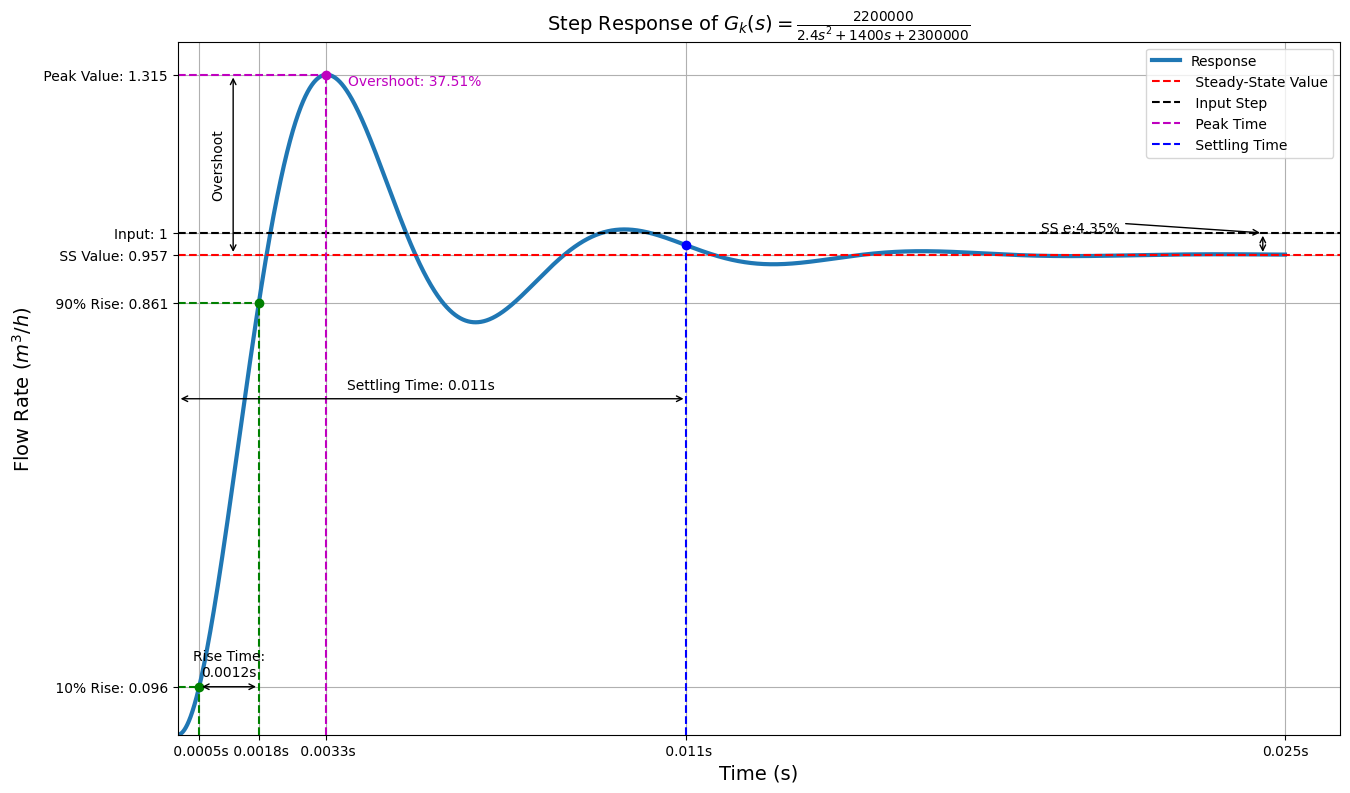

In [11]:
# @title Open Loop Step Response
G_k = create_transfer_function()
time = generate_time_vector()
time, response = get_step_response(G_k, time)
info = ct.step_info(G_k)
plot_step_response(time, response, info, annotate=True,
                   title=r"Step Response of $G_k(s) = \frac{2200000}{2.4s^2 + 1400s + 2300000}$",
                   ylabel=r"Flow Rate ($m^3/h$)")

+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 |     Rise Time      | 0.021 |
| 1 |   Settling Time    | 0.039 |
| 2 |    Settling Min    | 0.901 |
| 3 |    Settling Max    |  1.0  |
| 4 |     Overshoot      |  0.0  |
| 5 |     Undershoot     |  0.0  |
| 6 |        Peak        | 0.999 |
| 7 |     Peak Time      | 0.069 |
| 8 | Steady-State Value |  1.0  |
| 9 | Steady-State Error |  0.0  |
+---+--------------------+-------+


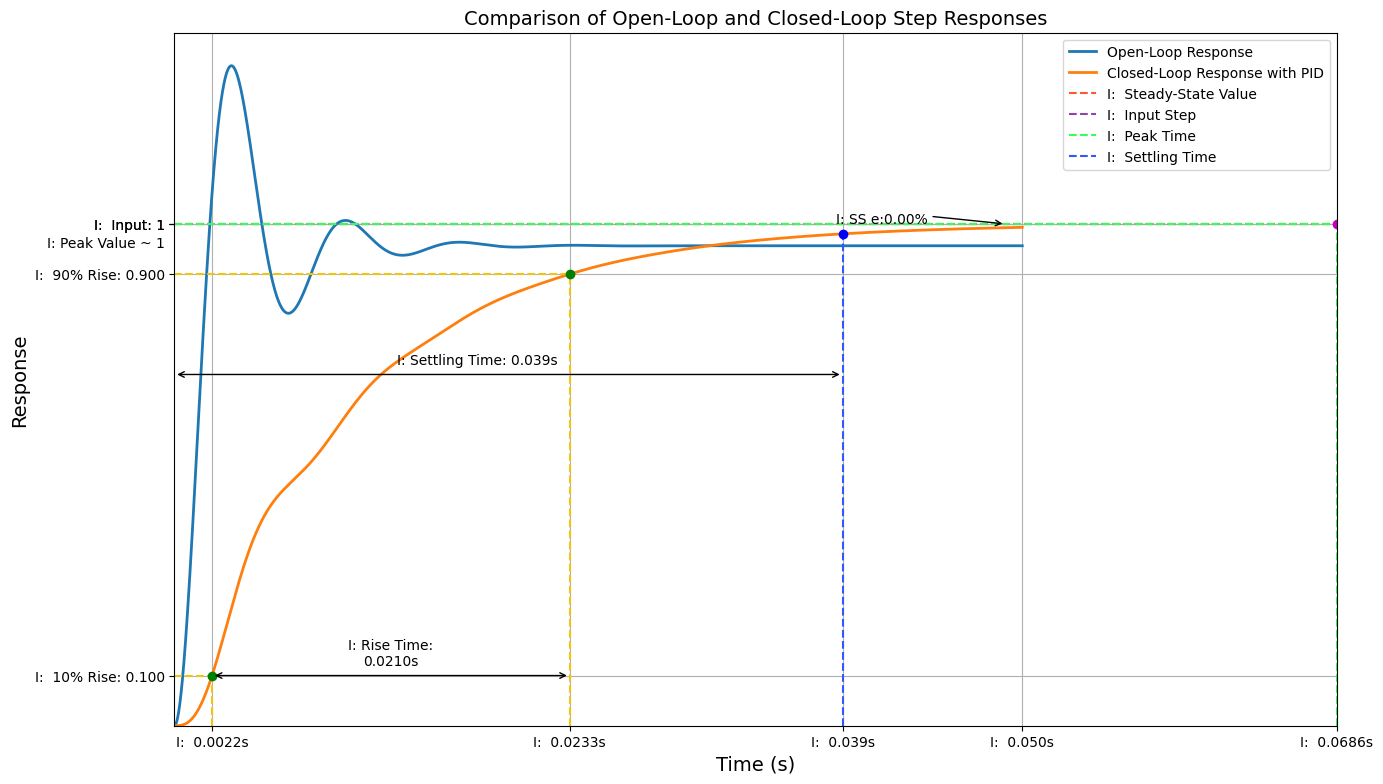

In [12]:
# @title Try 1: I controller
Kp = 0
Ki = 100
Kd = 0
compare_open_with_PID(G_k, generate_time_vector(end=0.05), Kp=Kp, Ki=Ki, Kd=Kd, annotate_closed=True, annotate_open=False, show_closed_metrics=True, prefix='I: ')

+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 |     Rise Time      | 0.009 |
| 1 |   Settling Time    | 0.018 |
| 2 |    Settling Min    | 0.907 |
| 3 |    Settling Max    |  1.0  |
| 4 |     Overshoot      |  0.0  |
| 5 |     Undershoot     |  0.0  |
| 6 |        Peak        | 0.999 |
| 7 |     Peak Time      | 0.033 |
| 8 | Steady-State Value |  1.0  |
| 9 | Steady-State Error |  0.0  |
+---+--------------------+-------+


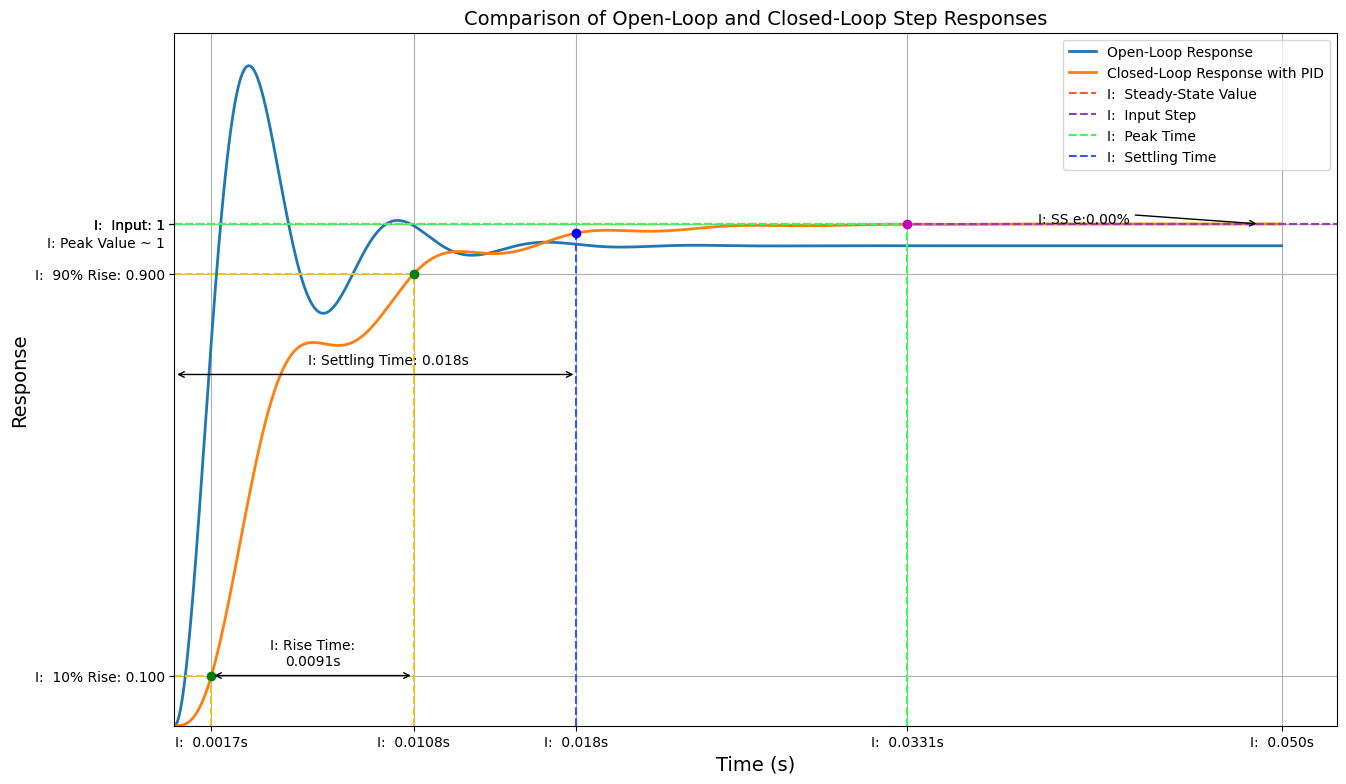

In [13]:
# @title Try 2: I controller
Kp = 0
Ki = 200
Kd = 0
compare_open_with_PID(G_k, generate_time_vector(end=0.05), Kp=Kp, Ki=Ki, Kd=Kd, annotate_closed=True, annotate_open=False, show_closed_metrics=True, prefix='I: ')

+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 |     Rise Time      | 0.009 |
| 1 |   Settling Time    | 0.013 |
| 2 |    Settling Min    | 0.905 |
| 3 |    Settling Max    |  1.0  |
| 4 |     Overshoot      |  0.0  |
| 5 |     Undershoot     |  0.0  |
| 6 |        Peak        |  1.0  |
| 7 |     Peak Time      | 0.028 |
| 8 | Steady-State Value |  1.0  |
| 9 | Steady-State Error |  0.0  |
+---+--------------------+-------+


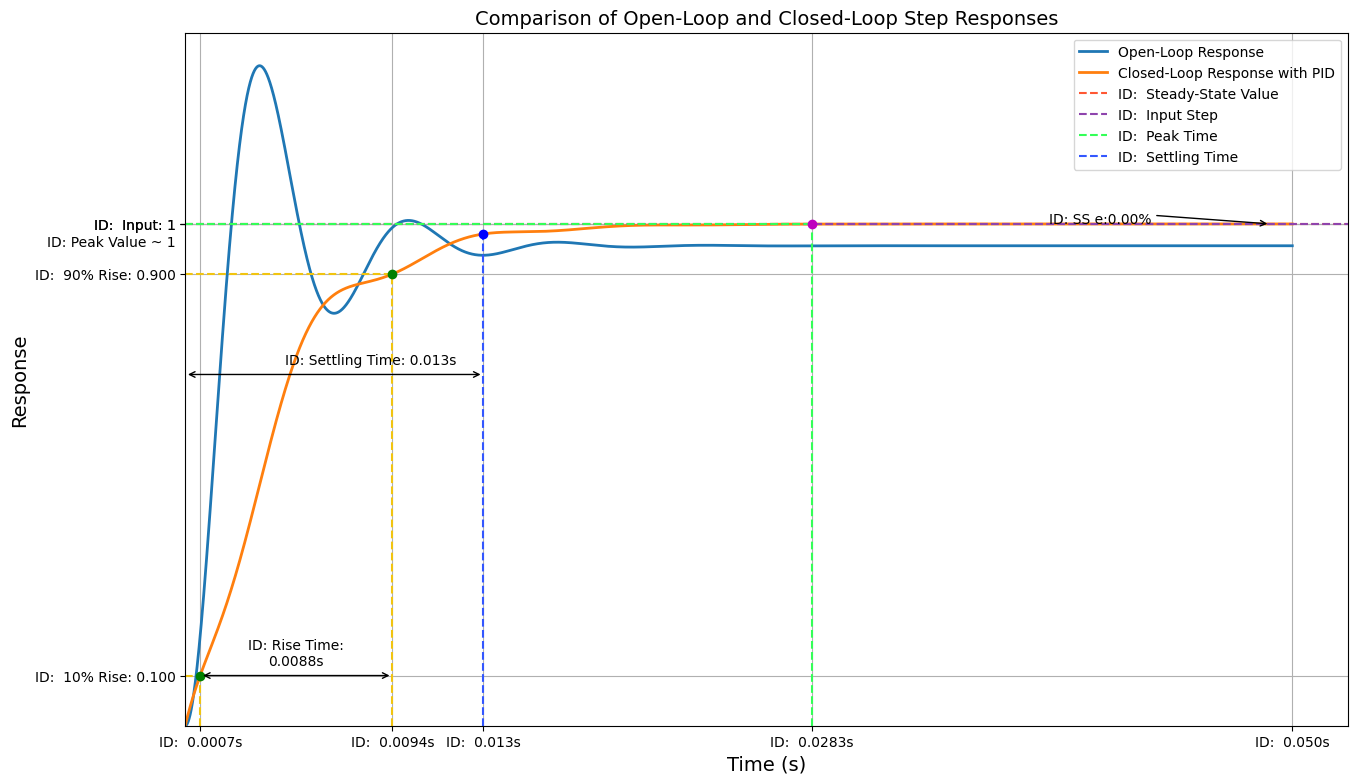

In [14]:
# @title Try 3: ID controller
Kp = 0
Ki = 250
Kd = 0.0002
compare_open_with_PID(G_k, generate_time_vector(end=0.05), Kp=Kp, Ki=Ki, Kd=Kd, annotate_closed=True, annotate_open=False, show_closed_metrics=True, prefix='ID: ')

+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 |     Rise Time      | 0.009 |
| 1 |   Settling Time    | 0.016 |
| 2 |    Settling Min    | 0.901 |
| 3 |    Settling Max    |  1.0  |
| 4 |     Overshoot      |  0.0  |
| 5 |     Undershoot     |  0.0  |
| 6 |        Peak        | 0.999 |
| 7 |     Peak Time      | 0.028 |
| 8 | Steady-State Value |  1.0  |
| 9 | Steady-State Error |  0.0  |
+---+--------------------+-------+


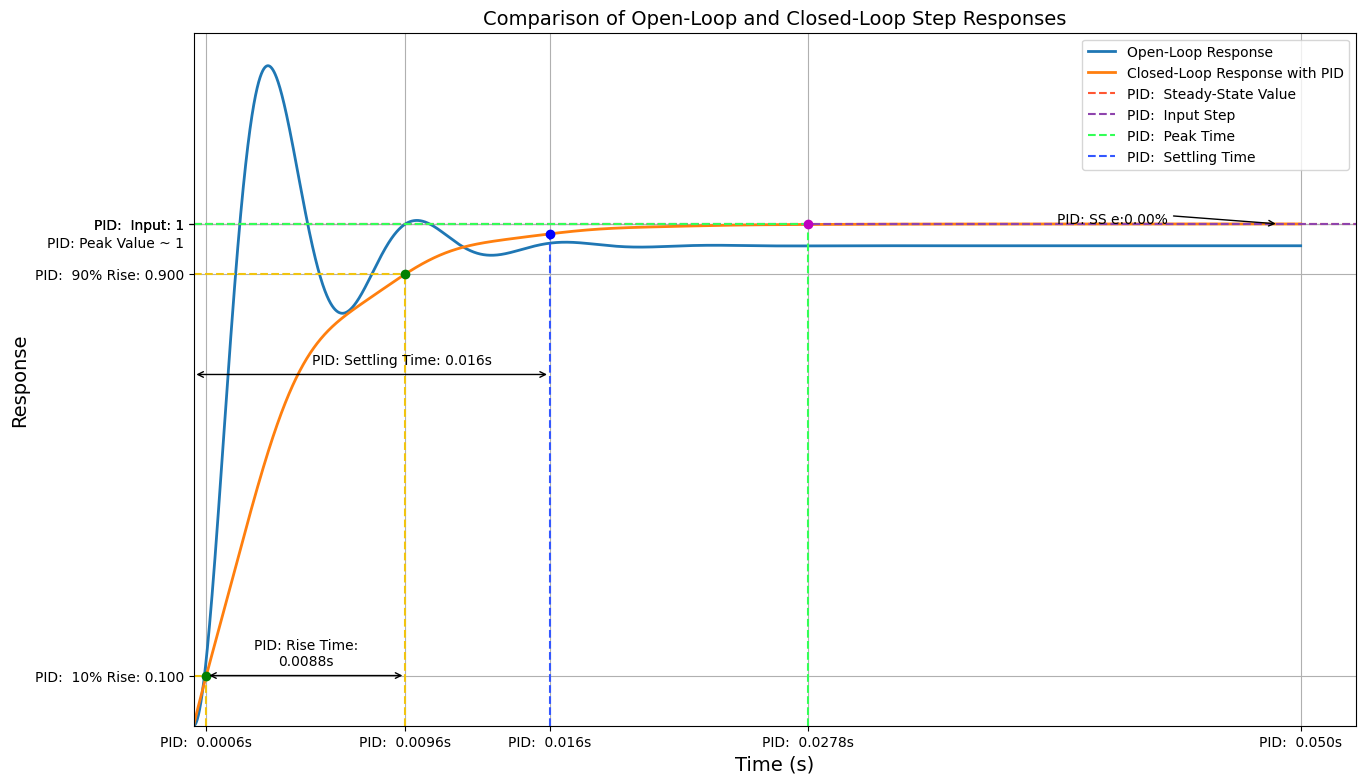

In [15]:
# @title Try 4: PID controller
Kp = 0.1
Ki = 250
Kd = 0.0002
compare_open_with_PID(G_k, generate_time_vector(end=0.05), Kp=Kp, Ki=Ki, Kd=Kd, annotate_closed=True, annotate_open=False, show_closed_metrics=True, prefix='PID: ')

+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 |     Rise Time      | 0.008 |
| 1 |   Settling Time    | 0.014 |
| 2 |    Settling Min    | 0.902 |
| 3 |    Settling Max    |  1.0  |
| 4 |     Overshoot      |  0.0  |
| 5 |     Undershoot     |  0.0  |
| 6 |        Peak        | 0.999 |
| 7 |     Peak Time      | 0.025 |
| 8 | Steady-State Value |  1.0  |
| 9 | Steady-State Error |  0.0  |
+---+--------------------+-------+


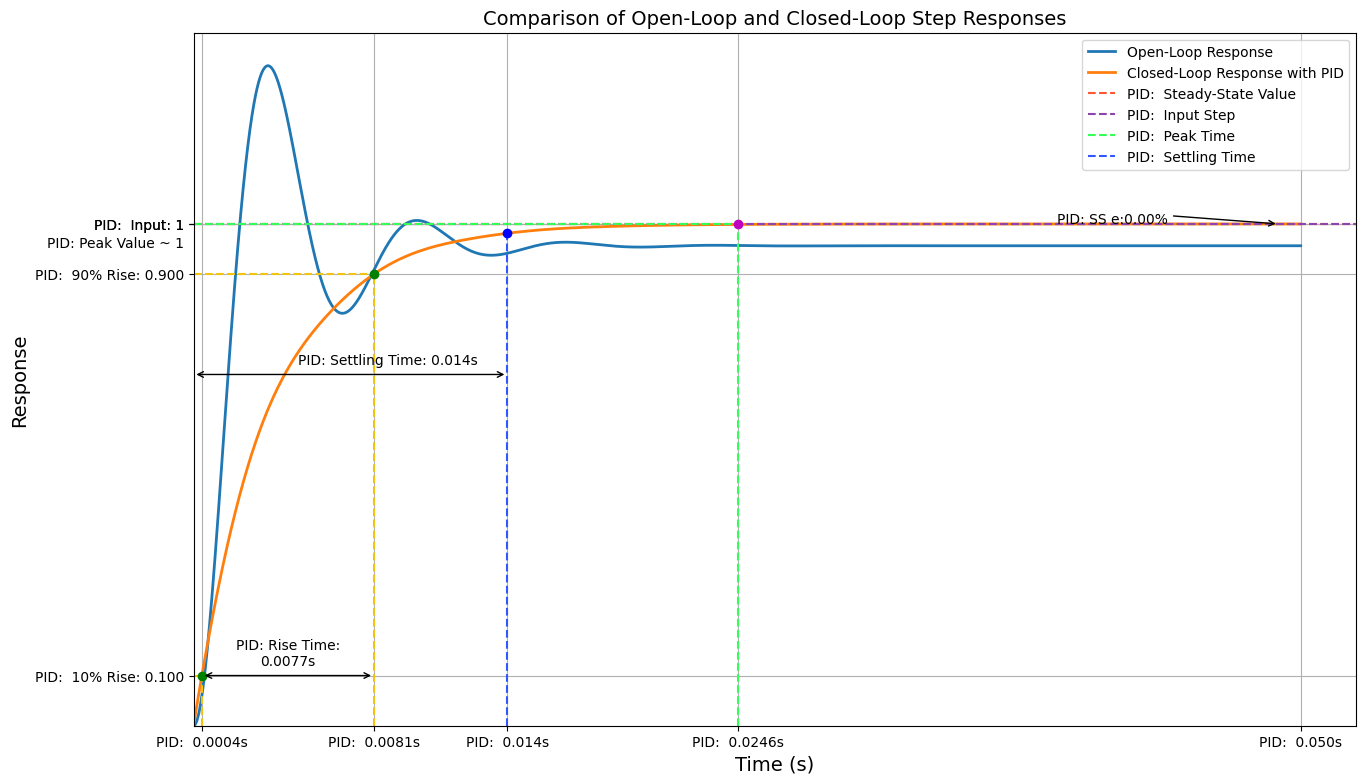

In [16]:
# @title Try 5: PID controller
Kp = 0.2
Ki = 300
Kd = 0.0003
compare_open_with_PID(G_k, generate_time_vector(end=0.05), Kp=Kp, Ki=Ki, Kd=Kd, annotate_closed=True, annotate_open=False, show_closed_metrics=True, prefix='PID: ')

In [33]:
# @title Function to calculate cost function for PID tuning
def pid_cost(params, G_k):
    Kp, Ki, Kd = params  # Unpack parameters

    # Create the PID controller with current gains
    PID_controller = ct.TransferFunction([Kd, Kp, Ki], [1, 0])

    # Closed-loop system
    closed_loop_system = ct.feedback(PID_controller * G_k, 1)

    # Step response
    time, response = ct.step_response(closed_loop_system)

    # Calculate desired metrics
    overshoot = max(0, (max(response) - 1) * 100)  # percentage overshoot
    steady_state_error = abs(1 - response[-1])      # absolute steady-state error
    settling_time = time[next(i for i, v in enumerate(response) if abs(v - 1) <= 0.02)]

    # Define the cost function as a weighted sum of errors
    # Weighing factors can be adjusted depending on priorities
    cost = (settling_time * 50) + (overshoot * 100) + (steady_state_error * 50)

    return cost

Optimal PID gains: Kp = 0.1828577523148563, Ki = 300.00023201629443, Kd = 0.0011313990127294702
+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 |     Rise Time      | 0.008 |
| 1 |   Settling Time    | 0.011 |
| 2 |    Settling Min    | 0.902 |
| 3 |    Settling Max    |  1.0  |
| 4 |     Overshoot      |  0.0  |
| 5 |     Undershoot     |  0.0  |
| 6 |        Peak        | 0.997 |
| 7 |     Peak Time      | 0.015 |
| 8 | Steady-State Value |  1.0  |
| 9 | Steady-State Error |  0.0  |
+---+--------------------+-------+


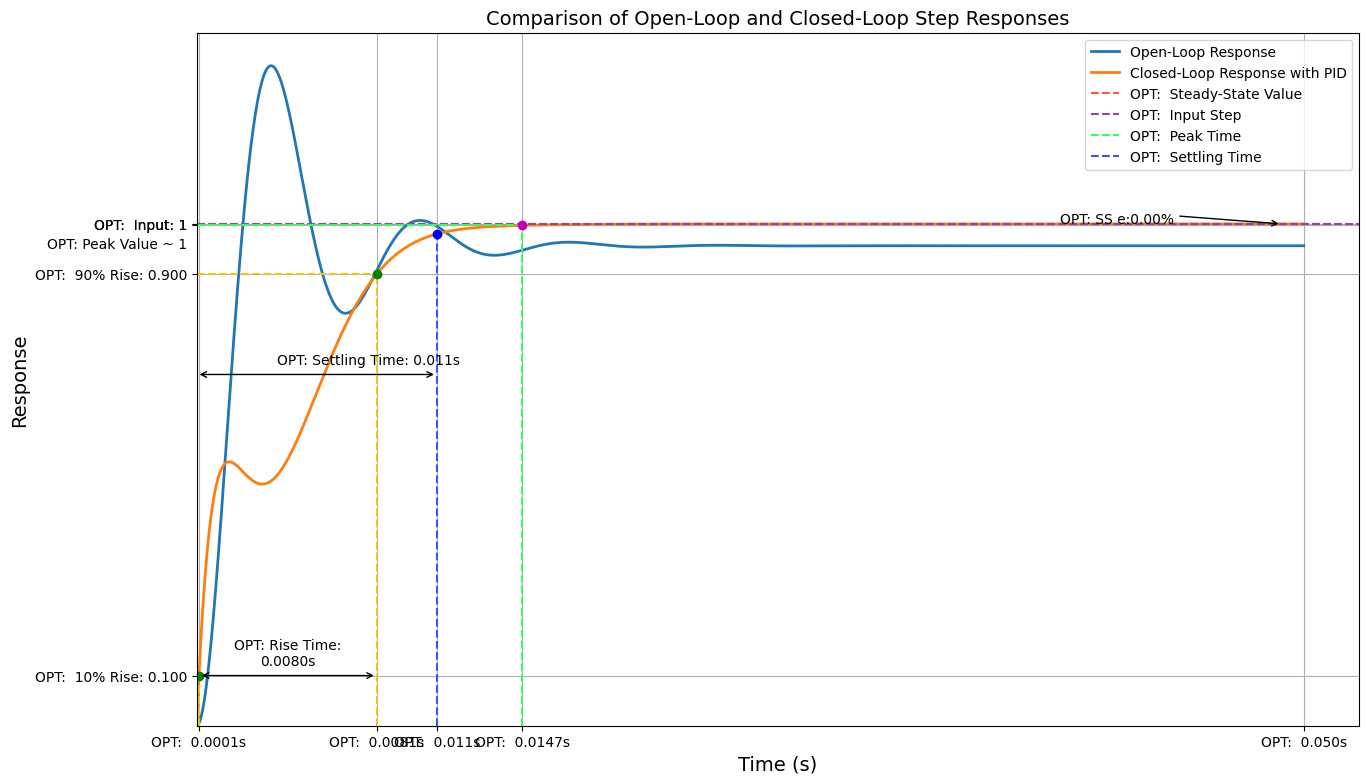

In [36]:
G_k = create_transfer_function()

# Initial guess for the PID parameters
initial_guess = [0.2, 300, 0.0003]  # Start with the manually tuned values

# Use minimize to find the optimal PID gains
result = minimize(pid_cost, initial_guess, args=(G_k,), bounds=[(0, 1), (0, 1000), (0, 0.01)])
Kp_opt, Ki_opt, Kd_opt = result.x

print(f"Optimal PID gains: Kp = {Kp_opt}, Ki = {Ki_opt}, Kd = {Kd_opt}")

compare_open_with_PID(G_k, generate_time_vector(end=0.05), Kp=Kp_opt, Ki=Ki_opt, Kd=Kd_opt, annotate_closed=True, annotate_open=False, show_closed_metrics=True, prefix='OPT: ')